In [2]:
from netCDF4 import Dataset
import numpy as np
#from numba import jit
from scipy.special import gamma as gam

def readScatProf(fname):
    fh=Dataset(fname,'r')
    temp=fh['temperature'][:]
    mass=fh['mass'][:]
    fraction=fh['fraction'][:]
    bscat=fh['bscat'][:]*4*np.pi
    Deq=10*(mass*1e3*6/np.pi)**(0.333) # in mm
    ext=fh['ext'][:]
    scat=fh['scat'][:]
    g=fh['g'][:]
    vfall=fh['fall_speed'][:]
    return temp,mass,fraction,bscat,Deq,ext,scat,g,vfall

def readScatProfR(fname):
    fh=Dataset(fname,'r')
    temp=fh['temperature'][:]
    mass=fh['mass'][:]
    bscat=fh['bscat'][:]*4*np.pi
    Deq=10*(mass*1e3*6/np.pi)**(0.333) # in mm
    ext=fh['ext'][:]
    vfall=fh['fall_speed'][:]
    scat=fh['scat'][:]
    g=fh['g'][:]
    #print(fh)
    #stop
    return temp,mass,bscat,Deq,ext,scat,g,vfall,fh

In [3]:
import glob
fss=sorted(glob.glob("/Users/mgrecu/scatteringProp/ice*nc"))
fsr=sorted(glob.glob("/Users/mgrecu/scatteringProp/water*nc"))

for f1,f2 in zip(fss,fsr):
    #print(f1,f2)
    freq1=f1.split("_")[1].split("-GHz")[0]
    freq2=f2.split("_")[1].split("-GHz")[0]
    print(freq1,freq2)
    tempI,massI,fractionI,bscatI,DeqI,extI,scatI,gI,vfallI=readScatProf(f1)
    tempR,massR,bscatR,DeqR,extR,scatR,gR,vfallR,fh=readScatProfR(f2)
    break

13.8 13.8


In [14]:
print(tempR.shape)
print(bscatI.shape)
print(tempI.shape)
print(bscatR.shape)

(5,)
(5, 25, 200)
(5,)
(5, 200)


In [39]:
def get_Zn(w,nw,lambd,W,Z,att,dm,dm_out,rrate_out,\
           kext,kscat,g,Deq,bscat,ext,scat,asym,vfall,mu,wl):
    dD=0.05
    rhow=1 #gcm-3
    Dint=np.arange(160)*dD+dD/2.0
    bscatInt=np.exp(np.interp(Dint,Deq,np.log(bscat)))  #m^2
    extInt=np.exp(np.interp(Dint,Deq,np.log(ext)))  #m^2
    vfallInt=np.interp(Dint,Deq,vfall)
    scatInt=np.exp(np.interp(Dint,Deq,np.log(scat)))  #m^2
    gInt=np.interp(Dint,Deq,(asym))  #m^2
    fact=1e3/np.pi**5/0.93*wl**4
    nP=W.shape[0]
    f_mu=6/4**4*(4+mu)**(mu+4)/gam(mu+4)
    #print(vfallInt)
    for j in range(nP):
        vdop=0
        nc0=0
        Vol=0
        #zray=0.0
        rrate=0.0
        for i in range(160):
            d=dD*i+dD/2
            Nd=f_mu*np.exp(-lambd[j]*d)*(d/dm[j])**mu*dD #(mm)
            W[j]=W[j]+nw[j]*Nd*(0.1*d)**3*np.pi/6*rhow*1e-3 #(g/m3)
            dm_out[j]=dm_out[j]+nw[j]*Nd*(0.1*d)**3*np.pi/6*rhow*(d)*1e-3 #(g/m3)
            Z[j]=Z[j]+nw[j]*Nd*bscatInt[i]
            vdop=vdop+nw[j]*Nd*bscatInt[i]*vfallInt[i]
            rrate=rrate+nw[j]*Nd*(0.1*d)**3*np.pi/6*vfallInt[i]
            att[j]=att[j]+nw[j]*Nd*extInt[i]*4.343 #(/km)
            kext[j]=kext[j]+nw[j]*Nd*extInt[i] #(/km)
            kscat[j]=kscat[j]+nw[j]*Nd*scatInt[i] #(/km)
            g[j]=g[j]+nw[j]*Nd*scatInt[i]*gInt[i] #(/km)
            nc0=nc0+nw[j]*Nd
            Vol=Vol+nw[j]*Nd*(1e-3*d)**3*np.pi/6
        Z[j]=np.log10(Z[j]*fact)*10
        dm_out[j]=dm_out[j]/(W[j]+1e-9)
        rrate_out[j]=rrate*3.6e-3

def calcZkuR(rwc,Deq_r,bscat_r,ext_r,scat_r,g_r,vfall_r,mu,wl):
    Nw=rwc.copy()*0+0.08e8
    dm=(4**4*rwc/(np.pi*1e6*Nw))**0.25*1e3 # in mm
    nwr=rwc.copy()*0.0+Nw
    w_r=rwc.copy()*0.0
    prate_r=rwc.copy()*0.0
    z_r=rwc.copy()*0.0
    att_r=rwc.copy()*0.0
    dm_r=rwc.copy()*0.0
    kext_out_r=rwc.copy()*0.0
    kscat_out_r=rwc.copy()*0.0
    g_out_r=rwc.copy()*0.0
    lambd=(4+mu)/dm
    get_Zn(rwc,nwr,lambd,w_r,z_r,att_r,dm,dm_r,\
           prate_r,kext_out_r,kscat_out_r,g_out_r,Deq_r,bscat_r[4,:],ext_r[4,:],\
           scat_r[4,:],g_r[4,:],\
           vfall_r,mu,wl)
    print(rwc.mean())
    print(w_r.mean())
    return nwr,z_r,att_r,prate_r,kext_out_r,kscat_out_r,g_out_r,dm_r,w_r

def calcZkuS(rwc,Deq_r,bscat_r,ext_r,scat_r,g_r,vfall_r,mu,wl,itemp,ifract):
    Nw=rwc.copy()*0+0.08e8
    dm=(4**4*rwc/(np.pi*1e6*Nw))**0.25*1e3 # in mm
    nwr=rwc.copy()*0.0+Nw
    w_r=rwc.copy()*0.0
    prate_r=rwc.copy()*0.0
    z_r=rwc.copy()*0.0
    att_r=rwc.copy()*0.0
    dm_r=rwc.copy()*0.0
    kext_out_r=rwc.copy()*0.0
    kscat_out_r=rwc.copy()*0.0
    g_out_r=rwc.copy()*0.0
    lambd=(4+mu)/dm
    get_Zn(rwc,nwr,lambd,w_r,z_r,att_r,dm,dm_r,\
           prate_r,kext_out_r,kscat_out_r,g_out_r,Deq_r[ifract,:],bscat_r[itemp,ifract,:],ext_r[itemp,ifract,:],\
           scat_r[itemp,ifract,:],g_r[itemp,ifract,:],\
           vfall_r[ifract,:],mu,wl)
    #get_Zn(rwc,nwr,lambd,w_s,z_s,att_s,dm,dm_s,\
    #       prate_s,Deq[14,:],bscat[3,14,:],ext[3,14,:],vfall[3,:],mu,wl)
    print(rwc.mean())
    print(w_r.mean())
    return nwr,z_r,att_r,prate_r,kext_out_r,kscat_out_r,g_out_r,dm_r,w_r

In [35]:
rwc=(np.logspace(-3,1,100))
print(rwc)
mu=2.0
wl=300/float(freq1)
nwr,z_r,att_r,prate_r,kext_out_r,kscat_out_r,g_out_r,dm_r,w_r=calcZkuR(rwc,DeqR,bscatR,extR,scatR,gR,vfallR,mu,wl)


[1.00000000e-03 1.09749877e-03 1.20450354e-03 1.32194115e-03
 1.45082878e-03 1.59228279e-03 1.74752840e-03 1.91791026e-03
 2.10490414e-03 2.31012970e-03 2.53536449e-03 2.78255940e-03
 3.05385551e-03 3.35160265e-03 3.67837977e-03 4.03701726e-03
 4.43062146e-03 4.86260158e-03 5.33669923e-03 5.85702082e-03
 6.42807312e-03 7.05480231e-03 7.74263683e-03 8.49753436e-03
 9.32603347e-03 1.02353102e-02 1.12332403e-02 1.23284674e-02
 1.35304777e-02 1.48496826e-02 1.62975083e-02 1.78864953e-02
 1.96304065e-02 2.15443469e-02 2.36448941e-02 2.59502421e-02
 2.84803587e-02 3.12571585e-02 3.43046929e-02 3.76493581e-02
 4.13201240e-02 4.53487851e-02 4.97702356e-02 5.46227722e-02
 5.99484250e-02 6.57933225e-02 7.22080902e-02 7.92482898e-02
 8.69749003e-02 9.54548457e-02 1.04761575e-01 1.14975700e-01
 1.26185688e-01 1.38488637e-01 1.51991108e-01 1.66810054e-01
 1.83073828e-01 2.00923300e-01 2.20513074e-01 2.42012826e-01
 2.65608778e-01 2.91505306e-01 3.19926714e-01 3.51119173e-01
 3.85352859e-01 4.229242

dict_keys(['kextG', 'kextS', 'kextH', 'kextR', 'salbG', 'salbS', 'salbH', 'salbR', 'asymG', 'asymS', 'asymH', 'asymR', 'dmr', 'dms', 'dmg', 'dmh', 'rwc', 'swc', 'gwc', 'hwc', 'rainRate', 'snowRate', 'graupRate', 'hailRate', 'zKuR', 'zKuS', 'zKuG', 'zKuH', 'zKaR', 'zKaS', 'zKaG', 'zKaH', 'attKuR', 'attKuS', 'attKuG', 'attKuH', 'attKaR', 'attKaS', 'attKaG'])


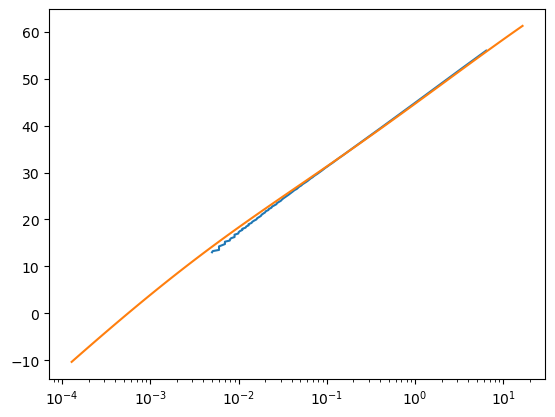

In [45]:
#print(z_r)
#print(DeqR)
#print(z_r[0:5],dm_r[0:5],rwc[0:5])
#print(z_r[-5:],dm_r[-5:],rwc[-5:])
import matplotlib.pyplot as plt
import netCDF4 as nc
with nc.Dataset("/Users/mgrecu/myPythonPackages/lookupTables/scatteringTablesGPM.nc") as f:
    print(f.variables.keys())
    rwcDPR=f["rwc"][:]
    zKuR=f["zKuR"][:]
    attKuR=f["attKuR"][:]

plt.semilogx(attKuR[100:273],zKuR[100:273])
plt.semilogx(att_r[:],z_r[:])
#plt.semilogx(w_r[:],z_r[:273])
#plt.ylim(40,50)
#plt.xlim(1,3)
#plt.grid()